In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

## Multi Agent Research System

This notebook combines all the previous components into a single system plus adds the final report generation step.

<img src="./assets/complete_deep_research_flow.png" width=800/>

In [2]:
%%writefile ../src/deep_research_with_langgraph/research_agent_full.py
"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""


from deep_research_with_langgraph.state_scope import AgentState,AgentInputState
from deep_research_with_langgraph.prompts import final_report_generation_prompt
from deep_research_with_langgraph.utils import get_today_str
from deep_research_with_langgraph.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_with_langgraph.multi_agent_supervisor import supervisor_agent
from langchain_core.messages import HumanMessage
from langgraph.graph import START, StateGraph, END

# ===== Config =====

from langchain.chat_models import init_chat_model
writer_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000)

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_with_langgraph/research_agent_full.py


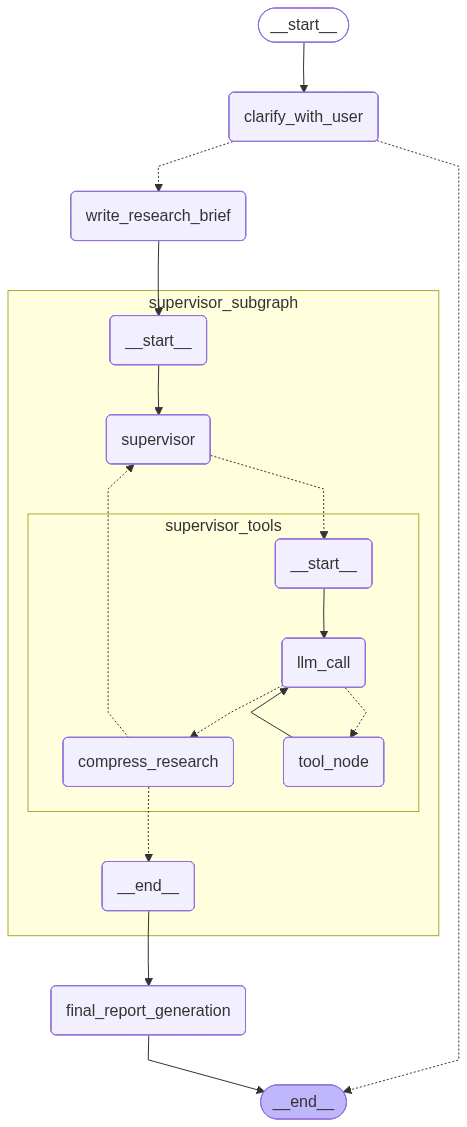

In [3]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_with_langgraph.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])